### 1. Get data 

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import pandas as pd
from numpy import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import decomposition, preprocessing, cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
def getdata():
    train = pd.read_csv("train.csv") 
    #train = train.sample(frac=0.1, replace=False)
    train_new = train
    
    features = train_new.columns
    cats = [feat for feat in features if 'cat' in feat]
    conts = [feat for feat in features if 'cont' in feat]
    dummies = pd.get_dummies(train_new[cats])
    normalized = preprocessing.MinMaxScaler().fit(train_new[conts]).transform(train_new[conts])
    normalized = pd.DataFrame(normalized,columns=conts)
    
    df_new = pd.concat((dummies,normalized,train_new.loss),axis=1)
    train_label_log = np.log(train['loss'])
    df_new = df_new.drop(train_label_log[train_label_log<4].index)
    df_new = df_new.sample(frac=0.1, replace=False)
    label_new = np.log(df_new.loss)
    df_new.drop('loss',axis=1, inplace=True)
    df_new = df_new.reset_index(drop=True)
    label_new = label_new.reset_index(drop=True)
    
    return df_new, label_new

In [3]:
X ,Y = getdata()

In [4]:
#### 4.1 Train and Test Split
#train_x = new_train.sample(frac=0.1, replace=False)
#train_y = label_new[train_x.index]
### 80% - 20% train and test split
X_train, X_test,y_train, y_test = cross_validation.train_test_split(X.values, Y.values, test_size=0.2, random_state=50)

### 2. Dimensionality Reduction

#### 2.1 Feature Selection

1 0.524736977498
6 0.48634721592
11 0.456862269657
16 0.447764794564
21 8842129.5537
26 123443663.288
31 346124530.443
36 180316471.134
41 298119649.924
46 328936118.229
51 743158068.303
56 938533347.198
61 884379736.523
66 1322031984.28
71 1323521981.58
76 1538291065.19
81 2483785671.9
86 2099734886.64
91 2099734886.64
96 2362503555.46
Optimal percentile of features:16 

Optimal number of features:184 



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


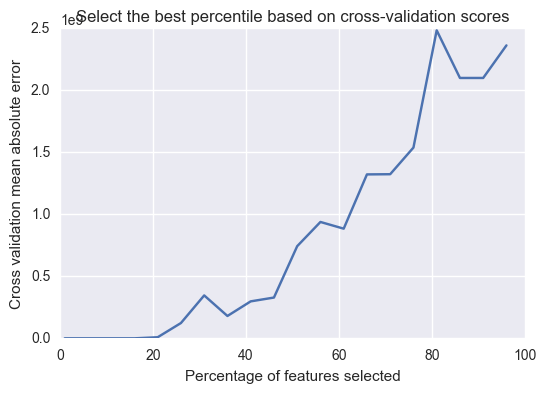

In [5]:
from sklearn import feature_selection
linreg = LinearRegression()
percentiles = range(1, 100, 5)
results = []
for i in range(1, 100, 5):
    fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = abs(cross_validation.cross_val_score(linreg, X_train_fs, y_train, cv=4, scoring='mean_absolute_error'))
    print (i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentil = np.where(results == results.min())[0]
print ("Optimal percentile of features:{0}".format(percentiles[optimal_percentil]), "\n")
optimal_num_features = int(floor(percentiles[optimal_percentil]*len(X.columns)/100))
print ("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
plt.figure()
plt.title("Select the best percentile based on cross-validation scores")
plt.xlabel("Percentage of features selected")
plt.ylabel("Cross validation mean absolute error")
plt.plot(percentiles,results)

In [6]:
fs = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=11)
X_fs = fs.fit_transform(X, Y)

In [7]:
### 80% - 20% train and test split
X_train_fs, X_test_fs,y_train_fs, y_test_fs = cross_validation.train_test_split(X_fs, Y.values, test_size=0.2, random_state=50)

#### 2.2 Principal Component Analysis

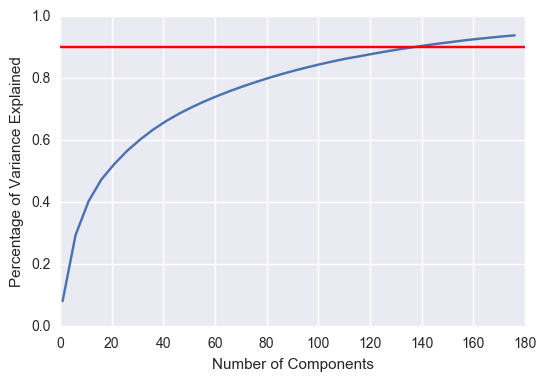

In [8]:
### Let's try different number of components
explained_variance = []
for i in range(1,180,5):
    pca = decomposition.PCA(n_components=i)
    df_norm_trans = pca.fit(X).transform(X)
    explained_variance.append(sum(pca.explained_variance_ratio_))
plt.plot(list(range(1,180,5)),explained_variance)
plt.axhline(y=0.9, color='r', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
#plt.xticks(range(0,10))
plt.show()

In [13]:
### Transfrom the data using 130 PCA components
pca = decomposition.PCA(n_components=130)
X_pca = pca.fit(X).transform(X)
X_pca = pd.DataFrame(X_pca)
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,1.078948,0.941560,0.526496,1.399544,0.173179,0.774034,-0.423142,-0.618021,-0.216185,0.405388,...,-0.169362,-0.086992,-0.336242,-0.531480,-0.384792,0.076366,-0.327845,0.326654,0.085755,-0.112852
1,-2.843812,-0.919305,0.915955,-0.794838,0.756917,1.149071,-1.826663,0.779493,-1.050749,0.198075,...,0.042026,0.304588,-0.150022,-0.135055,-0.209241,-0.020902,-0.152928,0.062810,-0.131366,0.226195
2,-0.243852,-1.490185,-1.570814,0.039375,0.199423,1.402404,0.745216,0.098397,-0.121934,-0.832464,...,0.232793,0.051597,-0.080464,0.285461,0.018700,-0.123529,-0.076813,0.133076,-0.130677,0.113600
3,1.192799,0.597572,-1.389393,0.487895,0.399723,-0.228595,-0.682449,-1.462461,-0.048421,0.702762,...,0.346317,0.095886,0.225478,0.170763,-0.103955,-0.014845,0.026926,0.190965,0.207787,-0.081511
4,0.173639,-2.284774,-1.445100,0.251558,0.078433,-0.747610,0.323891,1.059422,-0.489916,1.530099,...,0.134158,-0.292823,-0.037580,-0.162517,-0.114285,0.061311,0.174766,0.324455,0.154630,-0.020416


In [14]:
X_pca = X_pca.reset_index(drop=True)

In [15]:
### 80% - 20% train and test split
X_train_pca, X_test_pca,y_train_pca, y_test_pca = cross_validation.train_test_split(X_pca.values, Y.values, test_size=0.2, random_state=50)

### 3. Data Modeling
    linear Regression
    Lasso Regression
    Ridge Regreesion
    Elastic Net Regression

#### 3.1 linear Regression

#### Linear Regression - Feature Selection

In [139]:
print('Linear Regression')
print('Using Selected Features')
print('MAE_train\t MAE_test\t ')
linreg = LinearRegression()
linreg.fit(X_train_fs, y_train_fs)
lig_mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(linreg.predict(X_train_fs)))
lig_mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(linreg.predict(X_test_fs)))

print('{:.3f}\t {:.4f}\t'.format(lig_mae_train, lig_mae_test))

Linear Regression
Using Selected Features
MAE_train	 MAE_test	 
1266.082	 1275.0274	


#### Linear Regression - PCA

In [140]:
print('Linear Regression')
print('PCA')
print('MAE_train\t MAE_test\t ')
linreg = LinearRegression()
linreg.fit(X_train_pca, y_train_pca)
lig_mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(linreg.predict(X_train_pca)))
lig_mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(linreg.predict(X_test_pca)))

print('{:.3f}\t {:.4f}\t'.format(lig_mae_train, lig_mae_test))

Linear Regression
PCA
MAE_train	 MAE_test	 
1265.172	 1270.2693	


#### 3.2 Lasso Regression

#### Lasso Regression - Feature Selection

In [224]:
from sklearn.linear_model import Lasso
print('Lasso Regression')
print('Using Selected Features')
print('alpha\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
alpha = np.linspace(0.0001,20,20)
la_fs_test_mae = np.array([])
la_fs_cv_mae = np.array([])
la_fs_train_mae = np.array([])
for a in alpha:
    Lass = Lasso(fit_intercept=True, alpha=a)

    ### computing the MAE on training data and testing data
    Lass.fit(X_train_fs, y_train_fs)
    mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(Lass.predict(X_train_fs)))
    mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(Lass.predict(X_test_fs)))
    
    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_fs), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        Lass.fit(X_fs[train], Y[train])
        predicted = Lass.predict(X_fs[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5
    
    la_fs_train_mae = np.append(la_fs_train_mae, [mae_train])
    la_fs_test_mae = np.append(la_fs_test_mae, [mae_test])
    la_fs_cv_mae = np.append(la_fs_cv_mae, [mae_5cv])
    print('{:.3f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Lasso Regression
Using Selected Features
alpha	 MAE_train	 MAE_test	 MAE_5cv

0.000	 1266.4300	 1272.6045	 1270.3549
0.053	 1552.4522	 1537.8544	 1548.1777
0.105	 1684.9454	 1672.4591	 1683.9081
0.158	 1780.5752	 1764.4050	 1778.4021
0.211	 1818.8454	 1801.9508	 1815.6547
0.263	 1818.8454	 1801.9508	 1815.6547
0.316	 1818.8454	 1801.9508	 1815.6547
0.368	 1818.8454	 1801.9508	 1815.6547
0.421	 1818.8454	 1801.9508	 1815.6547
0.474	 1818.8454	 1801.9508	 1815.6547
0.526	 1818.8454	 1801.9508	 1815.6547
0.579	 1818.8454	 1801.9508	 1815.6547
0.632	 1818.8454	 1801.9508	 1815.6547
0.684	 1818.8454	 1801.9508	 1815.6547
0.737	 1818.8454	 1801.9508	 1815.6547
0.789	 1818.8454	 1801.9508	 1815.6547
0.842	 1818.8454	 1801.9508	 1815.6547
0.895	 1818.8454	 1801.9508	 1815.6547
0.947	 1818.8454	 1801.9508	 1815.6547
1.000	 1818.8454	 1801.9508	 1815.6547


#### Lasso Regression - PCA

In [225]:
from sklearn.linear_model import Lasso
print('Lasso Regression')
print('Using PCA')
print('alpha\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
alpha = np.linspace(0.0001,20,20)
la_pca_test_mae = np.array([])
la_pca_cv_mae = np.array([])
la_pca_train_mae = np.array([])
for a in alpha:
    Lass = Lasso(fit_intercept=True, alpha=a)

    ### computing the MAE on training data and testing data
    Lass.fit(X_train_pca, y_train_pca)
    mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(Lass.predict(X_train_pca)))
    mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(Lass.predict(X_test_pca)))
    
    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_pca), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        Lass.fit(X_pca[train], Y[train])
        predicted = Lass.predict(X_pca[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5
    
    la_pca_train_mae = np.append(la_pca_train_mae, [mae_train])
    la_pca_test_mae = np.append(la_pca_test_mae, [mae_test])
    la_pca_cv_mae = np.append(la_pca_cv_mae, [mae_5cv])
    print('{:.3f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Lasso Regression
Using PCA
alpha	 MAE_train	 MAE_test	 MAE_5cv

0.000	 1264.9323	 1269.7629	 1271.9790
1.053	 1818.8454	 1801.9508	 1815.6547
2.105	 1818.8454	 1801.9508	 1815.6547
3.158	 1818.8454	 1801.9508	 1815.6547
4.211	 1818.8454	 1801.9508	 1815.6547
5.263	 1818.8454	 1801.9508	 1815.6547
6.316	 1818.8454	 1801.9508	 1815.6547
7.368	 1818.8454	 1801.9508	 1815.6547
8.421	 1818.8454	 1801.9508	 1815.6547
9.474	 1818.8454	 1801.9508	 1815.6547
10.526	 1818.8454	 1801.9508	 1815.6547
11.579	 1818.8454	 1801.9508	 1815.6547
12.632	 1818.8454	 1801.9508	 1815.6547
13.684	 1818.8454	 1801.9508	 1815.6547
14.737	 1818.8454	 1801.9508	 1815.6547
15.789	 1818.8454	 1801.9508	 1815.6547
16.842	 1818.8454	 1801.9508	 1815.6547
17.895	 1818.8454	 1801.9508	 1815.6547
18.947	 1818.8454	 1801.9508	 1815.6547
20.000	 1818.8454	 1801.9508	 1815.6547


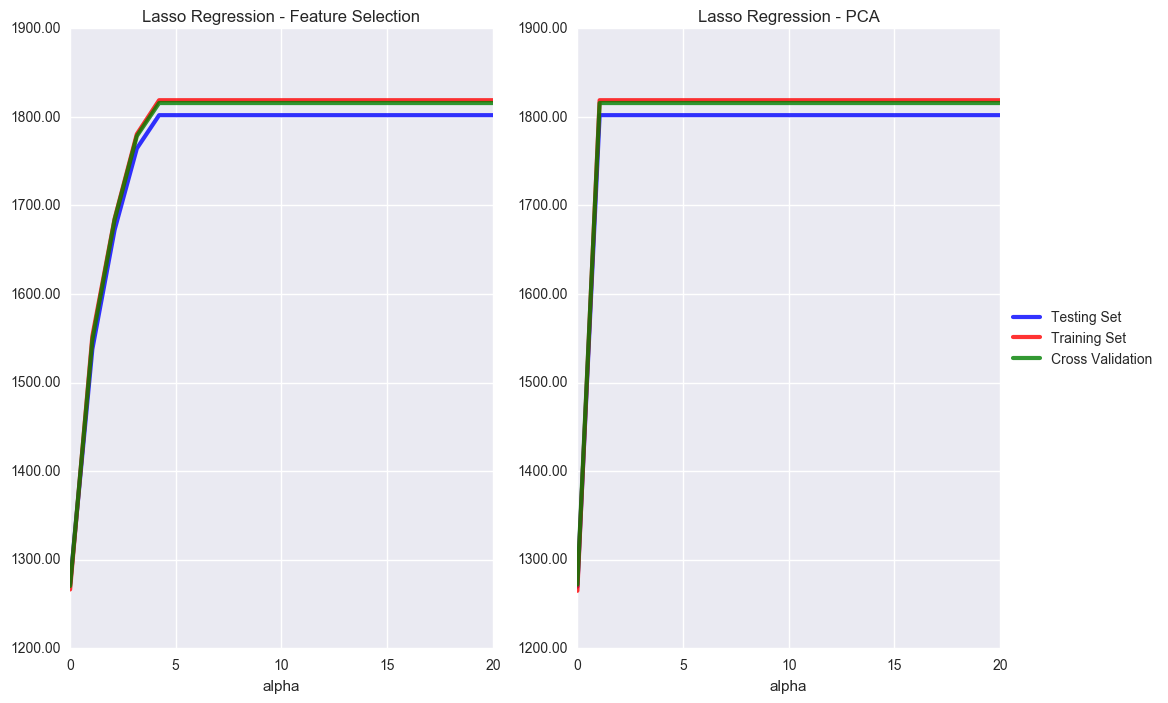

In [228]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.plot(alpha, la_fs_test_mae, label='Testing Set', alpha=0.8, lw=3, c='b')
ax1.plot(alpha, la_fs_train_mae, label='Training Set', alpha=0.8, lw=3, c='r')
ax1.plot(alpha, la_fs_cv_mae, label='Cross Validation', alpha=0.8, lw=3, c='g')
#ax1.set_yticks(range(1264,1276,1))
ax1.set_xlabel("alpha")
ax1.set_title("Lasso Regression - Feature Selection")
ax1.set_label("Mean Absolute Error")

ax1 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.plot(alpha, la_pca_test_mae, label='Testing Set', alpha=0.8, lw=3, c='b')
ax1.plot(alpha, la_pca_train_mae, label='Training Set', alpha=0.8, lw=3, c='r')
ax1.plot(alpha, la_pca_cv_mae, label='Cross Validation', alpha=0.8, lw=3, c='g')
ax1.legend(loc=6,bbox_to_anchor=(1, 0.5))
#ax1.set_yticks(range(1264,1276,1))
ax1.set_xlabel("alpha")
ax1.set_title("Lasso Regression - PCA")
ax1.set_label("Mean Absolute Error")

#### 3.3 Ridge Regreesion

#### Ridege Regression - Feature Selection

In [205]:
print('Ridge Regression')
print('Using Selected Features')
print('alpha\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
alpha = np.linspace(0.0001,20,20)
rid_fs_test_mae = np.array([])
rid_fs_cv_mae = np.array([])
rid_fs_train_mae = np.array([])
for a in alpha:
    ridge = Ridge(fit_intercept=True, alpha=a)

    ### computing the MAE on training data and testing data
    ridge.fit(X_train_fs, y_train_fs)
    mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(ridge.predict(X_train_fs)))
    mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(ridge.predict(X_test_fs)))
    
    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_fs), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        ridge.fit(X_fs[train], Y[train])
        predicted = ridge.predict(X_fs[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5
    
    rid_fs_train_mae = np.append(rid_fs_train_mae, [mae_train])
    rid_fs_test_mae = np.append(rid_fs_test_mae, [mae_test])
    rid_fs_cv_mae = np.append(rid_fs_cv_mae, [mae_5cv])
    print('{:.3f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Ridge Regression
Using Selected Features
alpha	 MAE_train	 MAE_test	 MAE_5cv

0.000	 1266.3772	 1275.4892	 1271.0028
1.053	 1266.4139	 1275.1665	 1270.9510
2.105	 1266.4284	 1274.8870	 1270.9014
3.158	 1266.4509	 1274.6649	 1270.8751
4.211	 1266.4712	 1274.4748	 1270.8534
5.263	 1266.4898	 1274.3073	 1270.8522
6.316	 1266.5185	 1274.1586	 1270.8607
7.368	 1266.5699	 1274.0251	 1270.8670
8.421	 1266.6323	 1273.9045	 1270.8784
9.474	 1266.6893	 1273.7999	 1270.8894
10.526	 1266.7408	 1273.7285	 1270.8986
11.579	 1266.7876	 1273.6621	 1270.9056
12.632	 1266.8313	 1273.6071	 1270.9106
13.684	 1266.8720	 1273.5573	 1270.9150
14.737	 1266.9101	 1273.5110	 1270.9215
15.789	 1266.9459	 1273.4672	 1270.9303
16.842	 1266.9817	 1273.4269	 1270.9378
17.895	 1267.0177	 1273.3903	 1270.9456
18.947	 1267.0563	 1273.3552	 1270.9545
20.000	 1267.0931	 1273.3222	 1270.9641


#### Ridege Regression - PCA

In [207]:
print('Ridge Regression')
print('Using PCA')
print('alpha\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
#X_pca = X_pca.values
alpha = np.linspace(0.0001,20,20)
rid_pca_cv_test_mae = np.array([])
rid_pca_cv_mae = np.array([])
rid_pca_cv_train_mae = np.array([])
for a in alpha:
    ridge = Ridge(fit_intercept=True, alpha=a)

    ### computing the MAE on training data and testing data
    ridge.fit(X_train_pca, y_train_pca)
    mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(ridge.predict(X_train_pca)))
    mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(ridge.predict(X_test_pca)))
    
    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_pca), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        ridge.fit(X_pca[train], Y[train])
        predicted = ridge.predict(X_pca[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5
    
    rid_pca_cv_train_mae = np.append(rid_pca_cv_train_mae, [mae_train])
    rid_pca_cv_test_mae = np.append(rid_pca_cv_test_mae, [mae_test])
    rid_pca_cv_mae = np.append(rid_pca_cv_mae, [mae_5cv])
    print('{:.3f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Ridge Regression
Using PCA
alpha	 MAE_train	 MAE_test	 MAE_5cv

0.000	 1265.1723	 1270.2693	 1272.3699
1.053	 1265.1427	 1270.2285	 1272.3348
2.105	 1265.1133	 1270.1878	 1272.2997
3.158	 1265.0840	 1270.1472	 1272.2648
4.211	 1265.0547	 1270.1066	 1272.2301
5.263	 1265.0256	 1270.0661	 1272.1955
6.316	 1264.9965	 1270.0257	 1272.1613
7.368	 1264.9677	 1269.9854	 1272.1274
8.421	 1264.9390	 1269.9452	 1272.0938
9.474	 1264.9105	 1269.9052	 1272.0603
10.526	 1264.8821	 1269.8652	 1272.0269
11.579	 1264.8537	 1269.8253	 1271.9936
12.632	 1264.8255	 1269.7855	 1271.9604
13.684	 1264.7973	 1269.7458	 1271.9273
14.737	 1264.7692	 1269.7061	 1271.8944
15.789	 1264.7412	 1269.6668	 1271.8616
16.842	 1264.7135	 1269.6275	 1271.8289
17.895	 1264.6863	 1269.5882	 1271.7964
18.947	 1264.6593	 1269.5494	 1271.7641
20.000	 1264.6324	 1269.5111	 1271.7319


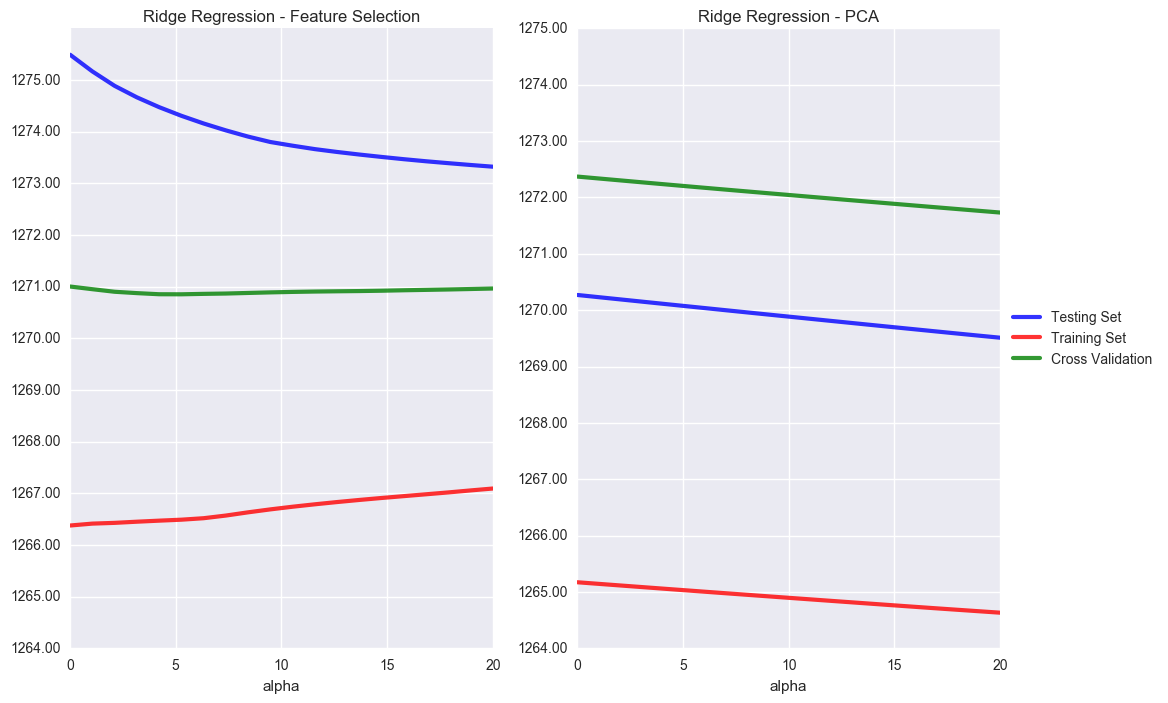

In [214]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.plot(alpha, rid_fs_test_mae, label='Testing Set', alpha=0.8, lw=3, c='b')
ax1.plot(alpha, rid_fs_train_mae, label='Training Set', alpha=0.8, lw=3, c='r')
ax1.plot(alpha, rid_fs_cv_mae, label='Cross Validation', alpha=0.8, lw=3, c='g')
ax1.set_yticks(range(1264,1276,1))
ax1.set_xlabel("alpha")
ax1.set_title("Ridge Regression - Feature Selection")
ax1.set_label("Mean Absolute Error")

ax1 = fig.add_subplot(122)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.plot(alpha, rid_pca_cv_test_mae, label='Testing Set', alpha=0.8, lw=3, c='b')
ax1.plot(alpha, rid_pca_cv_train_mae, label='Training Set', alpha=0.8, lw=3, c='r')
ax1.plot(alpha, rid_pca_cv_mae, label='Cross Validation', alpha=0.8, lw=3, c='g')
ax1.legend(loc=6,bbox_to_anchor=(1, 0.5))
ax1.set_yticks(range(1264,1276,1))
ax1.set_xlabel("alpha")
ax1.set_title("Ridge Regression - PCA")
ax1.set_label("Mean Absolute Error")

In [215]:
"""fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.plot(alpha, rid_fs_cv_mae, label='Feature Selection', alpha=0.8, lw=3, c='b')
ax1.plot(alpha, rid_pca_cv_mae, label='PCA', alpha=0.8, lw=3, c='r')
ax1.legend(loc=7)
#ax1.xlabel("alpha")
#ax1.patch.set_facecolor()
ax1.set_title("Ridge Regression 5 Fold Cross Validation")
#ax1.ylabel("Mean Absolute Error")"""

'fig = plt.figure(figsize=(12,6))\nax1 = fig.add_subplot(121)\nax1.yaxis.set_major_formatter(FormatStrFormatter(\'%.2f\'))\nax1.plot(alpha, rid_fs_cv_mae, label=\'Feature Selection\', alpha=0.8, lw=3, c=\'b\')\nax1.plot(alpha, rid_pca_cv_mae, label=\'PCA\', alpha=0.8, lw=3, c=\'r\')\nax1.legend(loc=7)\n#ax1.xlabel("alpha")\n#ax1.patch.set_facecolor()\nax1.set_title("Ridge Regression 5 Fold Cross Validation")\n#ax1.ylabel("Mean Absolute Error")'

#### 3.4 Elastic Net Regression

#### Elastic Net Regression - Feature Selection

In [241]:
print('Elastic Net Regression')
print('alpha\t l1_ratio\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
#alpha = np.linspace(0.0001,1,20)
alpha = np.linspace(0.0001,0.1,10)
l1_ratio = np.linspace(0, 1, 10)
EN_test_mae = np.array([])
EN_cv_mae = np.array([])
for a in alpha:
    elasticNet = ElasticNet(fit_intercept = True, alpha = a, max_iter=1000)

    ### computing the MAE on training data and testing data
    elasticNet.fit(X_train_fs, y_train_fs)
    mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(elasticNet.predict(X_train_fs)))
    mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(elasticNet.predict(X_test_fs)))

    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_fs), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        elasticNet.fit(X_fs[train], Y[train])
        predicted = elasticNet.predict(X_fs[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5

    EN_test_mae = np.append(EN_test_mae, [mae_test])
    EN_cv_mae = np.append(EN_cv_mae, [mae_5cv])
    print('{:.4f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))
### Best: a = 0.0001,  MAE_test = 1290

Elastic Net Regression
alpha	 l1_ratio	 MAE_train	 MAE_test	 MAE_5cv

0.0001	 1266.2726	 1273.5699	 1270.6018
0.0112	 1302.2024	 1297.7102	 1305.5306
0.0223	 1356.6415	 1345.4452	 1358.1714
0.0334	 1400.2962	 1383.8260	 1400.9263
0.0445	 1435.4408	 1415.2685	 1434.3632
0.0556	 1461.4307	 1441.6895	 1458.1441
0.0667	 1484.0918	 1465.5517	 1480.7937
0.0778	 1507.3679	 1489.8432	 1504.0852
0.0889	 1531.6488	 1514.8808	 1528.0388
0.1000	 1554.8637	 1538.5425	 1550.7245


#### Elastic Net Regression - PCA

In [242]:
print('Elastic Net Regression')
print('Using PCA')
print('alpha\t MAE_train\t MAE_test\t MAE_5cv\n')
#alpha = np.linspace(1,20,20)
#X_pca = X_pca.values
alpha = np.linspace(0.0001,0.1,10)
rid_pca_cv_test_mae = np.array([])
rid_pca_cv_mae = np.array([])
rid_pca_cv_train_mae = np.array([])
for a in alpha:
    elasticNet = ElasticNet(fit_intercept = True, alpha = a, max_iter=1000)

    ### computing the MAE on training data and testing data
    elasticNet.fit(X_train_pca, y_train_pca)
    mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(elasticNet.predict(X_train_pca)))
    mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(elasticNet.predict(X_test_pca)))
    
    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_pca), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        elasticNet.fit(X_pca[train], Y[train])
        predicted = elasticNet.predict(X_pca[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5
    
    rid_pca_cv_train_mae = np.append(rid_pca_cv_train_mae, [mae_train])
    rid_pca_cv_test_mae = np.append(rid_pca_cv_test_mae, [mae_test])
    rid_pca_cv_mae = np.append(rid_pca_cv_mae, [mae_5cv])
    print('{:.3f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Elastic Net Regression
Using PCA
alpha	 MAE_train	 MAE_test	 MAE_5cv

0.000	 1265.0256	 1269.9824	 1272.1412
0.011	 1299.4150	 1286.4525	 1298.3243
0.022	 1325.8860	 1308.4616	 1323.3996
0.033	 1346.2421	 1328.2807	 1343.6036
0.045	 1364.2691	 1345.5127	 1361.3563
0.056	 1381.8631	 1362.6025	 1379.1555
0.067	 1399.2246	 1378.6173	 1397.1310
0.078	 1415.9845	 1394.2477	 1414.6530
0.089	 1432.5504	 1410.4726	 1431.1612
0.100	 1447.9267	 1425.5452	 1445.0556


#### 3.5 SGD

#### SGD - Feature Selection

In [1]:
#sgdreg = SGDRegressor()
#param = {'penalty': ['l1', 'l2'],'alpha': np.linspace(0.0001,50, 100)}
#gs = GridSearchCV(sgdreg, param, verbose=2, cv=5)
#%time _ = gs.fit(X_fs, Y)

In [232]:
print ("The best parameters are %s" % (gs.best_params_))
print ("The best score is %0.4f" % (gs.best_score_))

The best parameters are {'penalty': 'l2', 'alpha': 0.0001}
The best score is 0.4823


In [234]:
sgdreg = SGDRegressor(penalty='l2', alpha= 0.0001).fit(X_train_fs, y_train_fs)
mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(sgdreg.predict(X_train_fs)))
mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(sgdreg.predict(X_test_fs)))
print(mae_train)
print(mae_test)

1274.03983626
1277.18281211


#### SGD - PCA

In [2]:
#sgdreg = SGDRegressor()
#param = {'penalty': ['l1', 'l2'],'alpha': np.linspace(0.0001,50, 100)}
#gs = GridSearchCV(sgdreg, param, verbose=2, cv=5)
#%time _ = gs.fit(X_pca, Y)

In [238]:
sgdreg = SGDRegressor(penalty='l1', alpha= 0.0001).fit(X_train_pca, y_train_pca)
mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(sgdreg.predict(X_train_pca)))
mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(sgdreg.predict(X_test_pca)))
print(mae_train)
print(mae_test)

1272.8904207
1279.95832784


### Random Forest Regression

#### RF - Feature Selection

In [4]:
#RF = RandomForestRegressor()
#param = {'n_estimators':[30,60,90],"criterion":['mae'],
#         'max_depth': [5,10,15],'min_samples_split':[5,10,15]}
#gs = GridSearchCV(RF, param, verbose=2,cv=3)
#%time _ = gs.fit(X_fs, Y)

In [5]:
#print ("The best parameters are %s" % (gs.best_params_))
#print ("The best score is %0.4f" % (gs.best_score_))

In [253]:
RF= RandomForestRegressor(max_depth = 5, min_samples_split = 10, n_estimators = 80).fit(X_train_fs, y_train_fs)
mae_train = mean_absolute_error(np.exp(y_train_fs), np.exp(RF.predict(X_train_fs)))
mae_test = mean_absolute_error(np.exp(y_test_fs), np.exp(RF.predict(X_test_fs)))
print(mae_train)
print(mae_test)

1329.07161574
1347.77113492


#### RF - PCA

In [19]:
### n_estimators
X_pca = X_pca.values
print('Random Forest Regressor')
print('n_estimators\t l1_ratio\t MAE_train\t MAE_test\t MAE_5cv\n')
max_depth = [5,10,15]
EN_test_mae = np.array([])
EN_cv_mae = np.array([])
for a in max_depth:

    rf = RandomForestRegressor(max_depth=a, n_estimators = 70)#max_depth=max_depth, n_estimators = a)

    ### computing the MAE on training data and testing data
    rf.fit(X_train_pca, y_train_pca)
    mae_train = mean_absolute_error(np.exp(y_train_pca), np.exp(rf.predict(X_train_pca)))
    mae_test = mean_absolute_error(np.exp(y_test_pca), np.exp(rf.predict(X_test_pca)))

    ### computing MAE using 5-fold cross validation
    kf = KFold(len(X_pca), n_folds=5)
    ave_mae = 0
    for train, test in kf:
        rf.fit(X_pca[train], Y[train])
        predicted = rf.predict(X_pca[test])
        mae = mean_absolute_error(np.exp(Y[test]), np.exp(predicted))
        ave_mae += mae
    mae_5cv = ave_mae / 5

    EN_test_mae = np.append(EN_test_mae, [mae_test])
    EN_cv_mae = np.append(EN_cv_mae, [mae_5cv])
    print('{:.4f}\t {:.4f}\t {:.4f}\t {:.4f}'.format(a, mae_train, mae_test, mae_5cv))

Random Forest Regressor
n_estimators	 l1_ratio	 MAE_train	 MAE_test	 MAE_5cv

5.0000	 1364.7586	 1370.7644	 1393.8734
10.0000	 1006.7268	 1297.9418	 1319.2788
15.0000	 663.8154	 1290.4929	 1308.2934


In [ ]:
RF = RandomForestRegressor()
param = {'n_estimators':np.arange(10,100,10),"criterion":['mae'],
         'max_depth': np.arange(5,30,50),'min_samples_split':[5,10,15,20]}
gs = GridSearchCV(RF, param, verbose=2,cv=3)
%time _ = gs.fit(X_fs, Y)